In [3]:
# Load all neccessary packages 
import pandas as pd
import warnings
import numpy as np
import sys
warnings.filterwarnings("ignore")
from noise_helpers.indicators import *
from noise_helpers.labels import *
from noise_helpers.is_class import *

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as tk
from matplotlib.ticker import PercentFormatter , NullFormatter
from collections import defaultdict
from sklearn.metrics import confusion_matrix

In [5]:
data = pd.read_csv("./Data/data.csv")
data = data.fillna(0)
data = data[(data["Leq"] != 0)]

### The RMSE between the Actual and the Downsampled 

In [7]:
def n_samples(F):
    N =[]
    for f in F:
        N.append((900 / int (f)))
    return N

rmse_values = []

L_indicators = [data["Leq"], data["L10"], data["L90"]]

L4_indicators = [data["Leq_4"], data["L10_4"], data["L90_4"]]
L10_indicators = [data["Leq_10"], data["L10_10"], data["L90_10"]]
L20_indicators = [data["Leq_20"], data["L10_20"], data["L90_20"]]
L30_indicators = [data["Leq_30"], data["L10_30"], data["L90_30"]]
L60_indicators = [data["Leq_60"], data["L10_60"], data["L90_60"]]
L120_indicators = [data["Leq_120"], data["L10_120"], data["L90_120"]]
L180_indicators = [data["Leq_180"], data["L10_180"], data["L90_180"]]
L300_indicators = [data["Leq_300"], data["L10_300"], data["L90_300"]]
L450_indicators = [data["Leq_450"], data["L10_450"], data["L90_450"]]
L900_indicators = [data["Leq_900"], data["L10_900"], data["L90_900"]]

Ln = [L_indicators, L4_indicators, L10_indicators, L20_indicators, L30_indicators, L60_indicators, L120_indicators, L180_indicators,
     L300_indicators, L450_indicators, L900_indicators ]

for indicator in Ln:
    for i in range (len(indicator)):
        rmse = np.sqrt (mean_squared_error ( indicator[i] , L_indicators[i]))
        
        if len(indicator[i].name.split('_')) == 1:
            m = indicator[i].name.split('_')[0] 
            f = 2
        else:
            f = indicator[i].name.split('_')[1]
            m = indicator[i].name.split('_')[0]
            
        rmse_values.append([m,f, rmse])

RMSE = pd.DataFrame(rmse_values , columns=["Indicator", "Frequency", "RMSE"])

RMSE["N"] = n_samples(RMSE["Frequency"])
RMSE_ = RMSE[RMSE["N" ] > 1]

In [8]:
col_x = [["Leq", "L10", "L90"], ["Leq_4", "L10_4", "L90_4"], ["Leq_10", "L10_10", "L90_10"],["Leq_20", "L10_20", "L90_20"],
        ["Leq_30", "L10_30" , "L90_30"], ["Leq_60", "L10_60", "L90_60"], ["Leq_120", "L10_120", "L90_120"],
        [ "Leq_180", "L10_180", "L90_180"], ["Leq_300", "L10_300", "L90_300"], ["Leq_450", "L10_450", "L90_450"], ["Leq_900", "L10_900", "L90_900"]]

col_y = col_x [0]
R2_corr = []
RMSE_corr = []
errors_corr = []

train = data.loc[data["week"] != 8].reset_index()
test = data.loc[data["week"] == 8].reset_index()

for x in col_x: 
    train_X = pd.DataFrame(data = train, columns = x)
    test_X = pd.DataFrame(data = test , columns = x)
                
    if len(x[0].split('_')) == 1:
        f = 2
    else:
        f = x[0].split('_')[1]
        
    n = 900/ int(f)
    train_X ["n"] = n
    test_X ["n"] = n
    
    for y in col_y:
        
        train_y = train[y]
        test_y = test[y]
        rf = RandomForestRegressor(n_estimators=100, max_features = 4, min_samples_leaf= 1, n_jobs= 8)
        rf.fit(train_X, train_y)
        y_pred_reg = rf.predict(test_X)
        r2 = r2_score(test_y , y_pred_reg)
        rmse = np.sqrt (mean_squared_error(test_y, y_pred_reg))
                   
        print ("#Samples: ", n , "\n", "Indicator: ", y, "\n", "R2 = ", r2, "\n", "RMSE: ", rmse )
        
        R2_corr.append([r2, y , n])
        RMSE_corr.append([rmse, y , n])
        
        for i in range(len(y_pred_reg)):
            error = test_y[i] - y_pred_reg[i]
            errors_corr.append([error, y , n])
            

#Samples:  450.0 
 Indicator:  Leq 
 R2 =  0.9999978667238392 
 RMSE:  0.0073276966521076715
#Samples:  450.0 
 Indicator:  L10 
 R2 =  0.9999992266848329 
 RMSE:  0.0051184953532458725
#Samples:  450.0 
 Indicator:  L90 
 R2 =  0.9999958604778358 
 RMSE:  0.006495529256468252
#Samples:  225.0 
 Indicator:  Leq 
 R2 =  0.9828261765684498 
 RMSE:  0.6574722678263585
#Samples:  225.0 
 Indicator:  L10 
 R2 =  0.9986507794480285 
 RMSE:  0.2137989279879959
#Samples:  225.0 
 Indicator:  L90 
 R2 =  0.9990015543039129 
 RMSE:  0.10087920747947188
#Samples:  90.0 
 Indicator:  Leq 
 R2 =  0.9779924514772181 
 RMSE:  0.7442687360755769
#Samples:  90.0 
 Indicator:  L10 
 R2 =  0.9936240147075558 
 RMSE:  0.4647695881749194
#Samples:  90.0 
 Indicator:  L90 
 R2 =  0.9959574419954729 
 RMSE:  0.20298669248334875
#Samples:  45.0 
 Indicator:  Leq 
 R2 =  0.9635253785374254 
 RMSE:  0.9581628734946994
#Samples:  45.0 
 Indicator:  L10 
 R2 =  0.9854502455338865 
 RMSE:  0.7020885356535111
#Samp

In [9]:
RMSE_corr = pd.DataFrame(RMSE_corr , columns=["RMSE_corr","Indicator_corr", "n"])
RMSE_corr_ = RMSE_corr[RMSE_corr["n" ] > 1]

RMSE_merge = pd.concat([RMSE , RMSE_corr], axis=1, join="inner")[["n", "Indicator", "RMSE", "RMSE_corr"]]
RMSE_merge_ = RMSE_merge[RMSE_merge["n"] > 4]
Leq_corr = RMSE_merge_[RMSE_merge_["Indicator"] == "Leq"]
L10_corr = RMSE_merge_[RMSE_merge_["Indicator"] == "L10"]
L90_corr = RMSE_merge_[RMSE_merge_["Indicator"] == "L90"]

(450, 5)

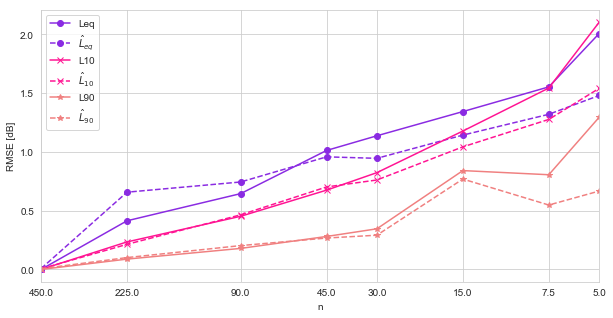

In [11]:
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

fig, ax = plt.subplots()

#plt.rcParams['figure.figsize'] = 16,16

fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot( 'n', 'RMSE', data=Leq_corr, marker='o', color='blueviolet', label = "Leq")
plt.plot( 'n', 'RMSE_corr', data=Leq_corr, marker='o', color='blueviolet',  label = "$\hat{L}_{eq}$" , linestyle='--')
plt.plot( 'n', 'RMSE', data=L10_corr, marker='x', color='deeppink', label = "L10")
plt.plot( 'n', 'RMSE_corr', data=L10_corr, marker='x', color='deeppink', label = "$\hat{L}_{10}$" , linestyle='--')
plt.plot( 'n', 'RMSE', data=L90_corr, marker='*', color='lightcoral', label = "L90")
plt.plot( 'n', 'RMSE_corr', data=L90_corr, marker='*', color='lightcoral', label = "$\hat{L}_{90}$", linestyle='--')
plt.legend()
plt.xscale('log')
plt.xlabel("n")
plt.ylabel("RMSE [dB]")
ax.set_xticks(RMSE_["N"].unique())
ax.get_xaxis().set_major_formatter(tk.ScalarFormatter())
plt.xlim((450,5))

### Histogram of the error after correction

In [12]:
data1 = data [data["week"] == 8].reset_index()


L_indicators = [data1["Leq"], data1["L10"], data1["L90"]]

L4_indicators = [data1["Leq_4"], data1["L10_4"], data1["L90_4"]]
L10_indicators = [data1["Leq_10"], data1["L10_10"], data1["L90_10"]]
L20_indicators = [data1["Leq_20"], data1["L10_20"], data1["L90_20"]]
L30_indicators = [data1["Leq_30"], data1["L10_30"], data1["L90_30"]]
L60_indicators = [data1["Leq_60"], data1["L10_60"], data1["L90_60"]]
L120_indicators = [data1["Leq_120"], data1["L10_120"], data1["L90_120"]]
L180_indicators = [data1["Leq_180"], data1["L10_180"], data1["L90_180"]]
L300_indicators = [data1["Leq_300"], data1["L10_300"], data1["L90_300"]]
L450_indicators = [data1["Leq_450"], data1["L10_450"], data1["L90_450"]]
L900_indicators = [data1["Leq_900"], data1["L10_900"], data1["L90_900"]]

Ln = [L_indicators, L4_indicators, L10_indicators, L20_indicators, L30_indicators, L60_indicators, L120_indicators, L180_indicators,
     L300_indicators, L450_indicators, L900_indicators ]


errors_values = []
for indicator in Ln:
    for i in range (len(indicator)):
        if len(indicator[i].name.split('_')) == 1:
            m = indicator[i].name.split('_')[0] 
            f = 2
        else:
            f = indicator[i].name.split('_')[1]
            m = indicator[i].name.split('_')[0]
        n = 900 /  int (f)
        for j in range (len (indicator[i])):
            error = indicator[i][j] - L_indicators[i][j]
            errors_values.append([m, n , error])
            

errors = pd.DataFrame(errors_values , columns=["Indicator", "n", "Error"])

In [13]:
ERR_corr = pd.DataFrame(errors_corr , columns=["Error","Indicator", "n"])
E_Ln = pd.DataFrame()
E_Ln["Leq225"] = ERR_corr[ERR_corr["Indicator"]=="Leq"][ERR_corr["n"] == 225]["Error"].values
E_Ln ["Leq90"] = ERR_corr[ERR_corr["Indicator"]=="Leq"][ERR_corr["n"] == 90]["Error"].values
E_Ln ["Leq30"] = ERR_corr[ERR_corr["Indicator"]=="Leq"][ERR_corr["n"] == 30]["Error"].values

E_Ln["L10_225"] = ERR_corr[ERR_corr["Indicator"]=="L10"][ERR_corr["n"] == 225]["Error"].values
E_Ln ["L10_90"] = ERR_corr[ERR_corr["Indicator"]=="L10"][ERR_corr["n"] == 90]["Error"].values
E_Ln ["L10_30"] = ERR_corr[ERR_corr["Indicator"]=="L10"][ERR_corr["n"] == 30]["Error"].values

E_Ln["L90_225"] = ERR_corr[ERR_corr["Indicator"]=="L90"][ERR_corr["n"] == 225]["Error"].values
E_Ln ["L90_90"] = ERR_corr[ERR_corr["Indicator"]=="L90"][ERR_corr["n"] == 90]["Error"].values
E_Ln ["L90_30"] = ERR_corr[ERR_corr["Indicator"]=="L90"][ERR_corr["n"] == 30]["Error"].values

E_Ln.mean()

Leq225     0.019504
Leq90      0.014665
Leq30     -0.042347
L10_225   -0.017372
L10_90    -0.001715
L10_30    -0.065654
L90_225    0.003420
L90_90    -0.006833
L90_30    -0.020180
dtype: float64

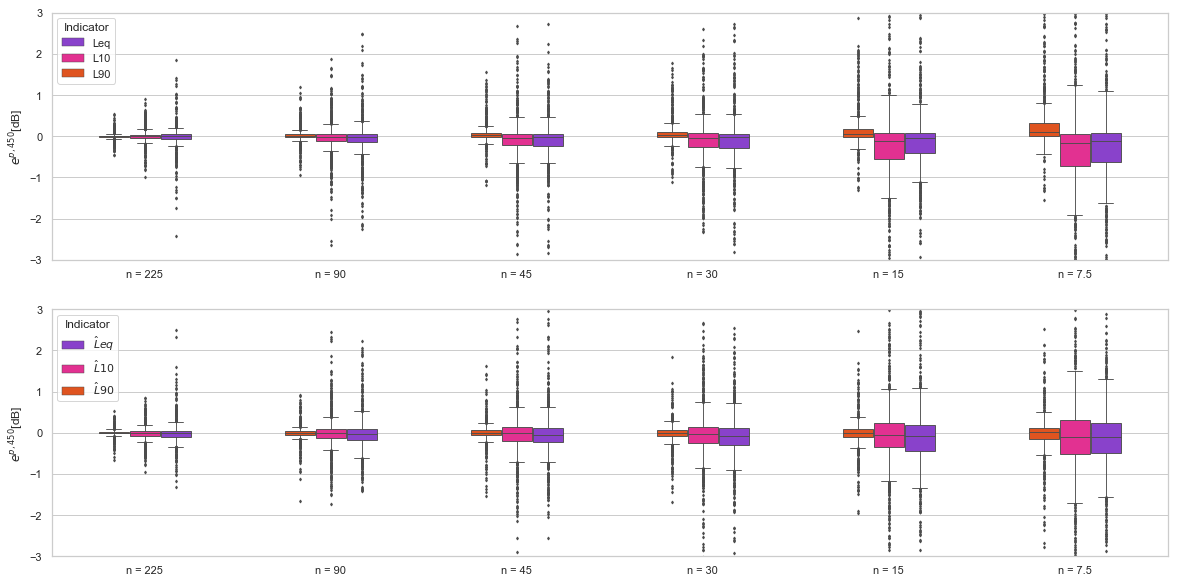

In [14]:
df1 = errors[errors["n"] > 5 ]
df1 = df1[df1["n"] <= 225]

df2 =  ERR_corr[ ERR_corr["n"] > 5 ]
df2 = df2[df2["n"] <= 225]


sns.set(style="whitegrid")
sns.set_palette(["blueviolet", "deeppink", "orangered"])
fig, ax = plt.subplots(2,1)
fig.set_size_inches(20, 10)



ax1 = sns.boxplot(x="n", y="Error",  hue="Indicator", data=df1, width = 0.5 , ax=ax[0], linewidth=0.9, fliersize=2)
ax1.set_xticklabels(["n = 7.5" , "n = 15", "n = 30" , "n = 45" , "n = 90" , "n = 225"])
ax1.invert_xaxis()
ax1.set_ylim((-3,3))
ax1.set(ylabel = "$e^{p,450}$[dB]", xlabel = "")

handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, ['Leq', 'L10' , 'L90'], title = "Indicator")


ax2 = sns.boxplot(x="n", y="Error",  hue="Indicator", data=df2, width = 0.5 , ax=ax[1], linewidth=0.9, fliersize=2)
ax2.set_ylim((-3,3))
ax2.set( ylabel = "$e^{p,450}$[dB]" , xlabel= "")
ax2.set_xticklabels(["n = 7.5" , "n = 15", "n = 30" , "n = 45" , "n = 90" , "n = 225"])
ax2.invert_xaxis()


handles, _ = ax2.get_legend_handles_labels()
ax2.legend(handles, ['$\hat Leq$', '$\hat L10$' , '$\hat L90$'], title = "Indicator")

## Classification for the bias correction

In [15]:
dd = defaultdict(list)
f1_values = []


Ll = [data["CQI_indicator"],data["CQI_indicator_4"], data["CQI_indicator_10"],  data["CQI_indicator_20"], data["CQI_indicator_30"],data["CQI_indicator_60"], data["CQI_indicator_120"], data["CQI_indicator_180"], data["CQI_indicator_300"],
     data["CQI_indicator_450"] , data["CQI_indicator_900"] ]

for label in Ll:
    f1 = f1_score( label , Ll[0], average="micro")
    cm = confusion_matrix(label, Ll[0], labels= ['Excellent', 'Good', 'Fair', 'Poor'])
    if len(label.name.split('_')) == 2:
        m = label.name.split('_')[0] 
        f = 2
    else:
        f = label.name.split('_')[2]
        m = label.name.split('_')[0]
    
    n = 900 / int(f)
    
    f1_values.append([m, f, f1])
    dd[n].append(cm)


F1 = pd.DataFrame(f1_values , columns=["Label", "Frequency", "F1"])
F1["N"] = n_samples(F1["Frequency"])
F1 = F1[F1["N"] > 1]

In [16]:
col_x = [["Leq", "L10", "L90"],
         ["Leq_4", "L10_4", "L90_4"],
         ["Leq_10", "L10_10", "L90_10"],
         ["Leq_20", "L10_20", "L90_20"],
        ["Leq_30", "L10_30" , "L90_30"], 
         ["Leq_60", "L10_60", "L90_60"],
         ["Leq_120", "L10_120", "L90_120"],
        ["Leq_180", "L10_180", "L90_180"], 
         ["Leq_300", "L10_300", "L90_300"], 
         ["Leq_450", "L10_450", "L90_450"],
         ["Leq_900", "L10_900", "L90_900"]]

db = defaultdict(list)

F1_corr = []

train = data[data['week'] != 8]
test = data[data['week'] == 8]

train_y = train["CQI_indicator"]
test_y = test["CQI_indicator"]

for x in col_x: 
            
    train_X = pd.DataFrame(data = train, columns = x)
    test_X = pd.DataFrame(data = test , columns = x)
                
    if len(x[0].split('_')) == 1:
        f = 2
    else:
        f = x[0].split('_')[1]
                    
    n = 900/ int(f)

    train_X ["n"] = n
    test_X ["n"] = n
        
    clf = RandomForestClassifier(n_estimators=100, max_features = 4, min_samples_leaf= 3, n_jobs= 8)
    clf.fit(train_X, train_y)
    y_pred_clf = clf.predict(test_X)

    f1 = f1_score(y_pred_clf , test_y, average="micro")
    cm = confusion_matrix(test_y, y_pred_clf, labels= ['Excellent', 'Good', 'Fair', 'Poor'])

    print ("#Samples: ", n , "\n", "F1: ", f1 )
        
    F1_corr.append([f1, n])
    db[n].append(cm)



#Samples:  450.0 
 F1:  1.0
#Samples:  225.0 
 F1:  0.9805680119581465
#Samples:  90.0 
 F1:  0.9805680119581465
#Samples:  45.0 
 F1:  0.9611360239162929
#Samples:  30.0 
 F1:  0.9671150971599403
#Samples:  15.0 
 F1:  0.9461883408071748
#Samples:  7.5 
 F1:  0.9252615844544095
#Samples:  5.0 
 F1:  0.922272047832586
#Samples:  3.0 
 F1:  0.8998505231689088
#Samples:  2.0 
 F1:  0.8819133034379671
#Samples:  1.0 
 F1:  0.8355754857997011


In [17]:
F1_corr = pd.DataFrame(F1_corr , columns=["F1", "n"])
F1_corr = F1_corr[F1_corr["n"] > 1]

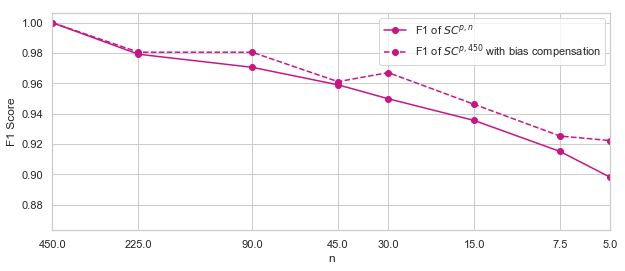

In [18]:
sns.set_palette(["mediumvioletred"])


fig, ax = plt.subplots()
#plt.rcParams['figure.figsize'] = 16,16
fig = plt.gcf()
fig.set_size_inches(10, 4)

plt.plot( 'N', 'F1', data=F1, marker='o', label = "F1 of $SC^{p,n}$")
plt.plot( "n", "F1", data=F1_corr, marker = 'o', label = "F1 of $SC^{p,450}$ with bias compensation", linestyle='--')

plt.xscale('log')
plt.xlabel("n")
plt.ylabel ("F1 Score")
plt.xlim(450,5)
plt.legend()
ax.set_xticks([450, 225, 90, 45, 30, 15, 7.5, 5]) 
ax.get_xaxis().set_major_formatter(tk.ScalarFormatter())